In [35]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
from supabase import create_client, Client
from dotenv import load_dotenv

load_dotenv()

url: str = os.environ.get("SUPABASE_URL")
key: str = os.environ.get("SUPABASE_KEY")
supabase: Client = create_client(url, key)


In [36]:
response = supabase.table("color_test_results").select("*").execute()

In [37]:
import pandas as pd

df = pd.DataFrame(response.data)
df = df.query("version == '0.0.3'")
df.version.value_counts()

version
0.0.3    123
Name: count, dtype: int64

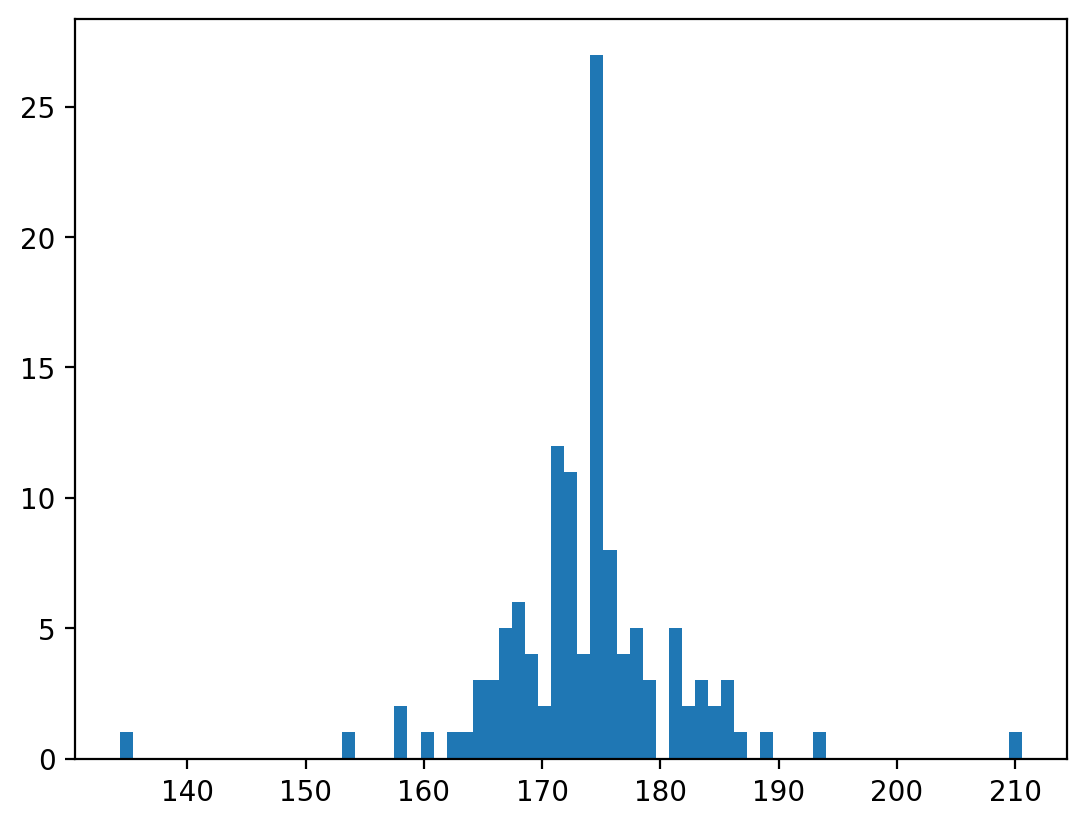

In [38]:
import matplotlib.pyplot as plt

counts, bins, _ = plt.hist(df.final_hue, bins=69)

In [43]:
import numpy as np

def calculate_boundaries(df):
    xy = df.final_hue.value_counts().sort_index().reset_index()
    final_hue_raw = xy["final_hue"].values
    raw_count = xy["count"].values
    raw_count = raw_count / raw_count.sum()

    count = np.cumsum(raw_count) / raw_count.sum()
    count = np.stack((np.concatenate(([0.0], count[:-1])), count), axis=1)
    final_hue = np.stack((final_hue_raw, final_hue_raw), axis=1)

    count = count.ravel()
    final_hue = final_hue.ravel()

    return final_hue_raw, raw_count, final_hue, count

[134.301141318471, 153.503134757856, 158.56843732322, 160.302303286645, 162.514185616824, 163.703518721884, 164.344468743918, 164.462960967657, 165.598525868342, 166.183872810368, 166.569970631419, 167.274647778639, 168.062663168801, 168.100946287479, 168.740805551753, 168.748424231721, 170.32506783527, 170.797793764671, 170.919085845105, 171.307445244332, 171.395734028347, 171.400305114026, 172.199075693101, 172.61121428121, 172.830304931291, 173.480824910454, 173.94544227512, 174.213265095317, 174.48866077117, 174.835812882413, 174.954335063876, 175.131828116511, 175.650024274329, 175.697288622681, 175.808227496496, 176.786011828223, 176.999731620381, 177.630359604473, 177.663397131833, 178.251972276788, 178.446882053225, 179.233902232735, 179.239221933239, 179.327841575664, 180.760778066761, 181.718757442617, 181.748027723212, 182.336602868167, 182.369640395527, 183.000268379619, 183.213988171777, 184.404787597005, 184.868171883489, 185.164187117587, 187.169695068709, 189.1868577287

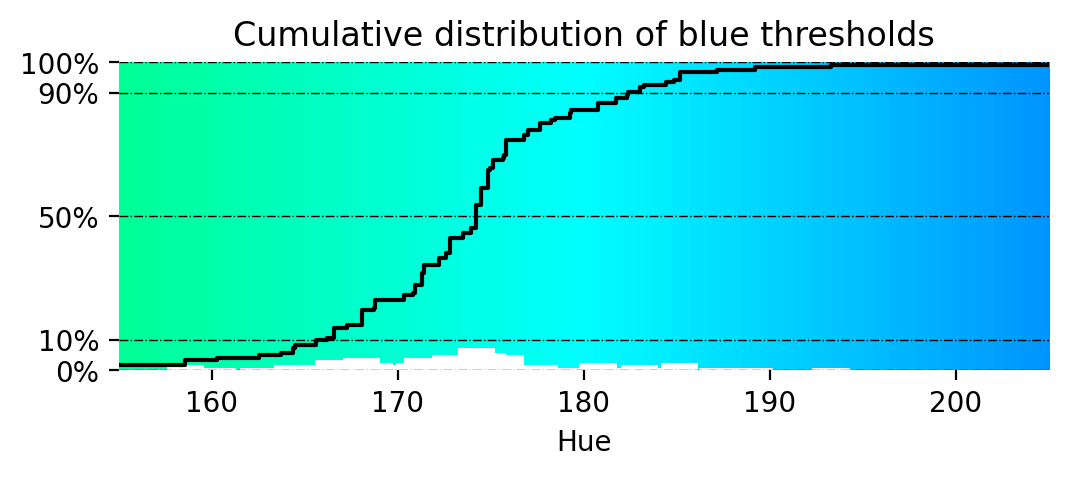

In [53]:
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle
from colorsys import hls_to_rgb

from colorsys import hls_to_rgb

def show_threshold(df, title="Cumulative distribution of blue thresholds"):
    data = []
    for i in range(120, 241):
        data.append(hls_to_rgb(i / 360, .5, 1))  # HSL(120, 100, 50)

    cmap = LinearSegmentedColormap.from_list("custom", data)
    bin_position, count, x_cdf, y_cdf = calculate_boundaries(df)
    print(json.dumps(list(bin_position)))
    print(json.dumps(list(count)))
    print(json.dumps(list(x_cdf)))
    print(json.dumps(list(y_cdf)))

    # Create gradient background
    gradient = np.linspace(0, 1, 256).reshape(1, -1)
    plt.figure(figsize=(6, 2))
    plt.imshow(gradient, aspect='auto', extent=[120, 240, 0, 1], cmap=cmap)

    plt.bar(bin_position, count, color='white', alpha=1, width=2)
    plt.plot(x_cdf, y_cdf, '-', color='black')

    plt.xlim((155, 205))
    plt.xlabel("Hue")
    plt.yticks([0, .1, .5, .9, 1], ["0%", "10%", "50%", "90%", "100%"])
    plt.box(False)
    plt.title(title)

    plt.grid(True, axis='y', color='black', linestyle='-.', linewidth=0.5)

show_threshold(df)

Device Type Distribution:
device_type
Android    46
iPhone     40
Other      37
Name: count, dtype: int64

Device Type Percentage:
device_type
Android    37.398374
iPhone     32.520325
Other      30.081301
Name: count, dtype: float64


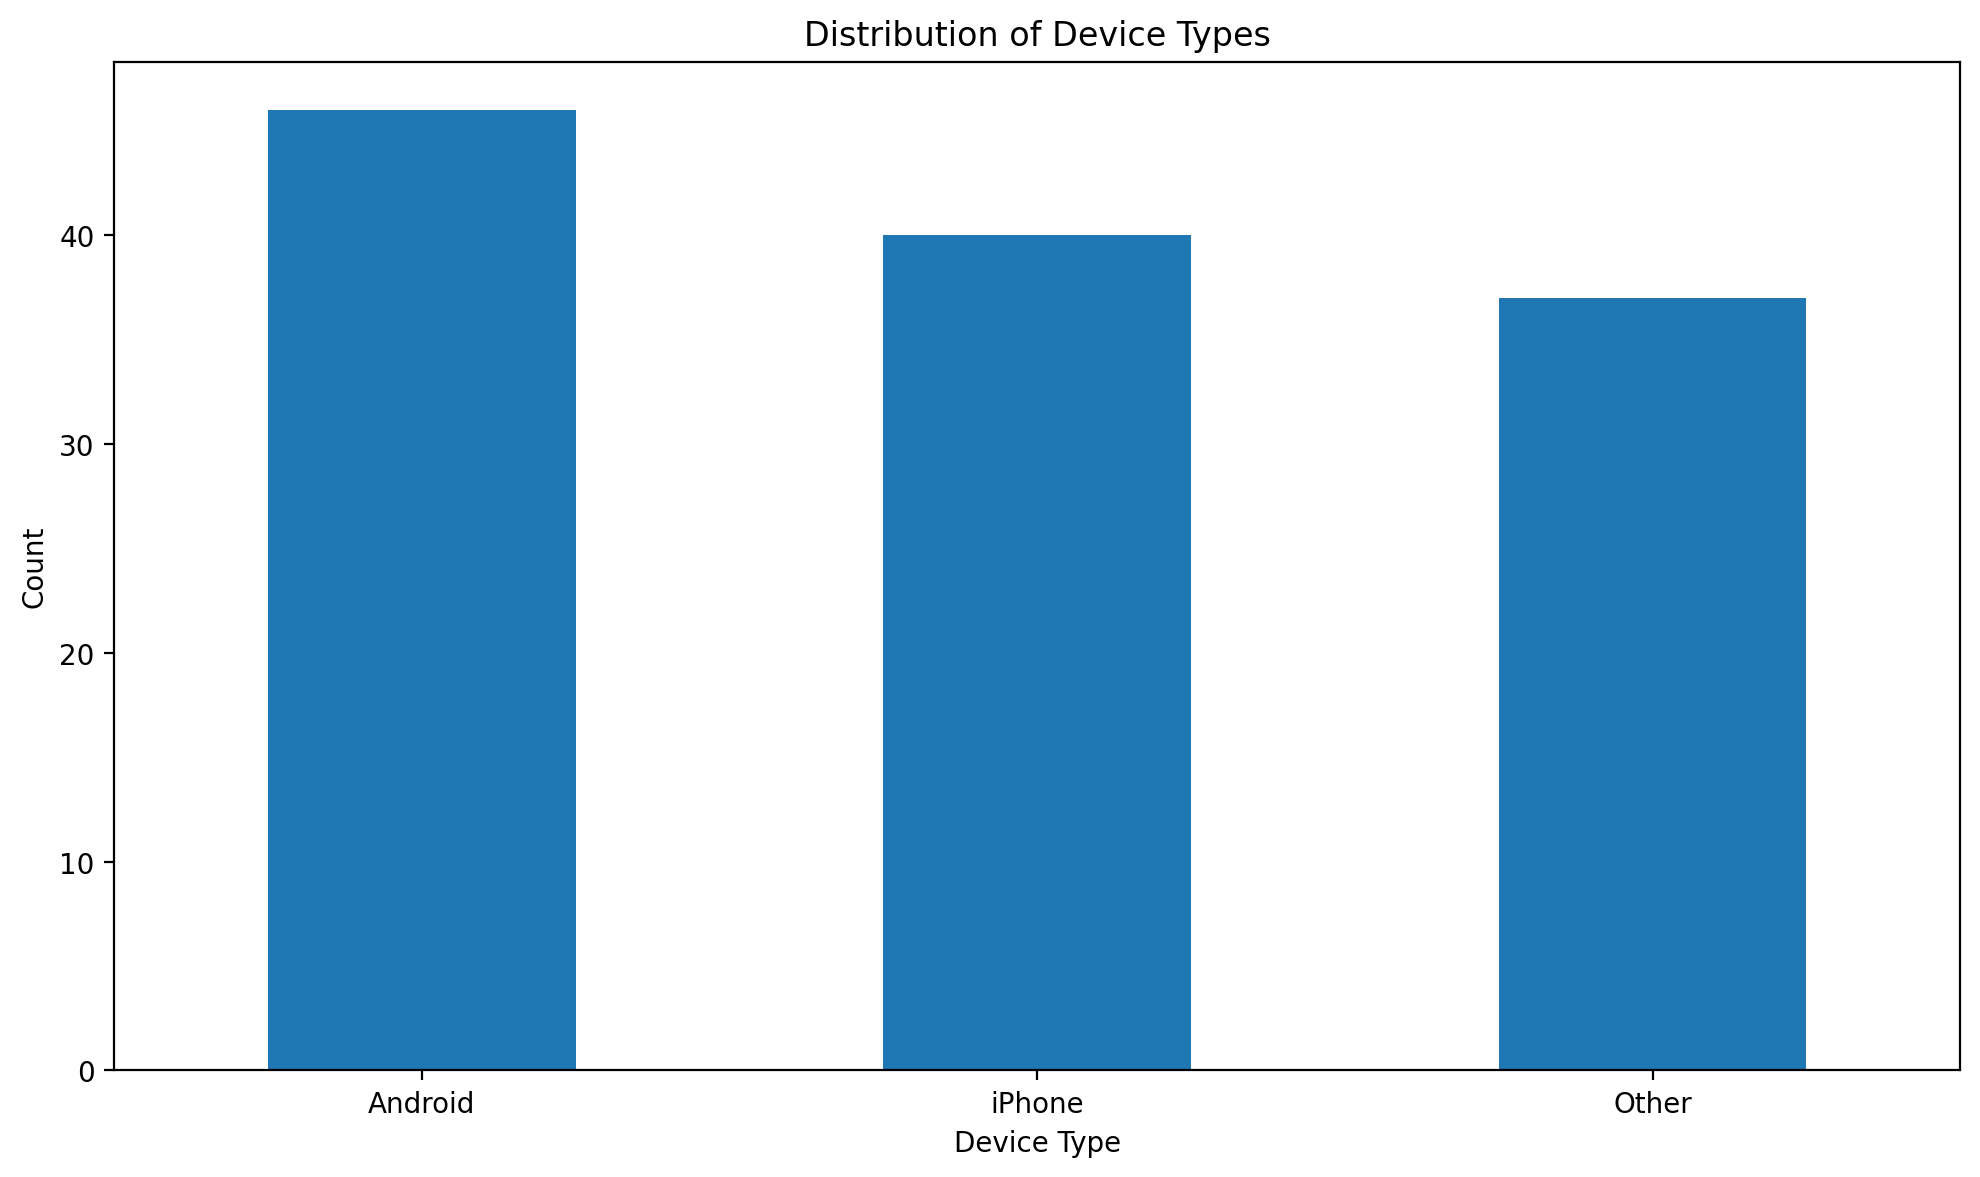

In [42]:
# Create a coarse classifier in terms of iPhone vs. Android vs. other
# Create a coarse classifier for iPhone vs. Android vs. other
def classify_device(user_agent):
    user_agent = user_agent.lower()
    if 'iphone' in user_agent:
        return 'iPhone'
    elif 'android' in user_agent:
        return 'Android'
    else:
        return 'Other'

# Apply the classifier to the user_agent column
df['device_type'] = df['user_agent'].apply(classify_device)

# Display the distribution of device types
device_distribution = df['device_type'].value_counts()
print("Device Type Distribution:")
print(device_distribution)

# Calculate the percentage distribution
device_percentage = device_distribution / len(df) * 100
print("\nDevice Type Percentage:")
print(device_percentage)

# Optionally, visualize the distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
device_distribution.plot(kind='bar')
plt.title('Distribution of Device Types')
plt.xlabel('Device Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


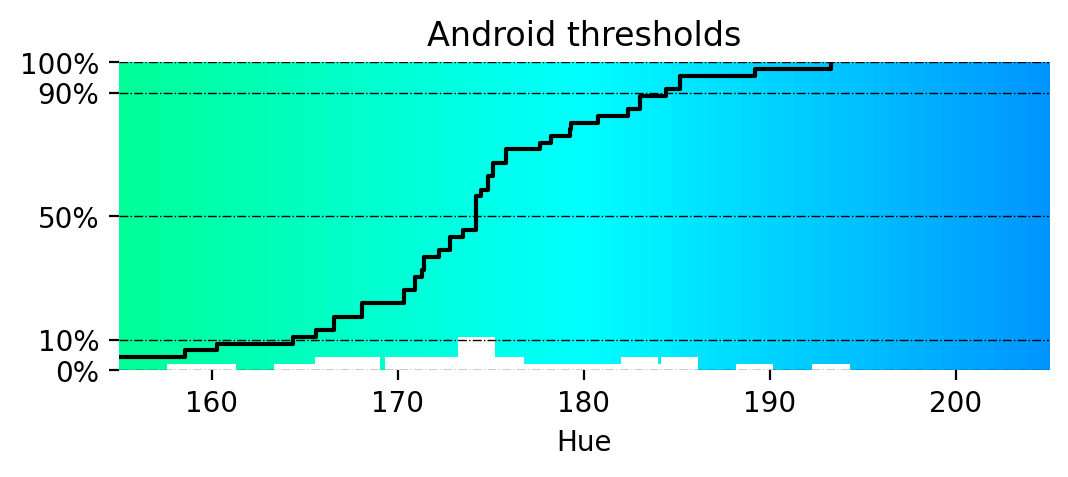

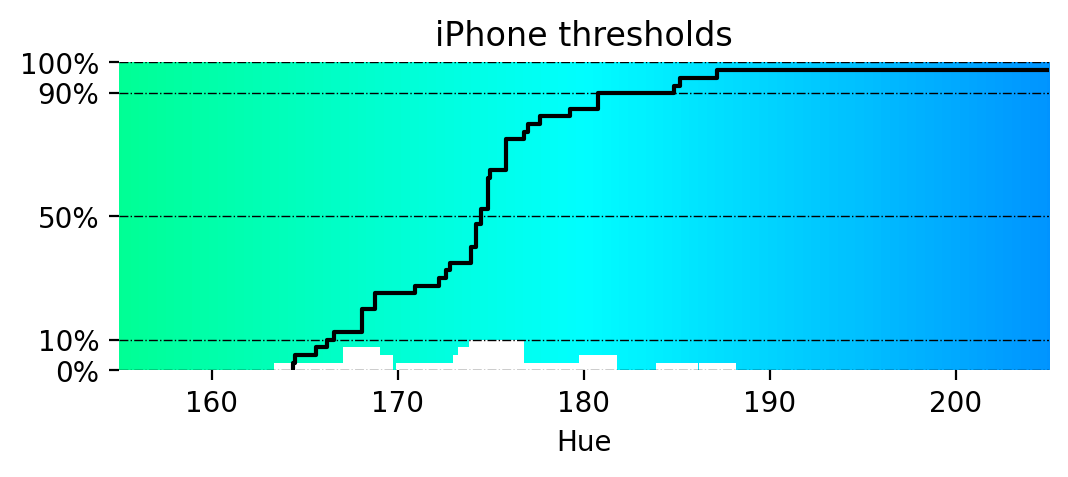

In [49]:
show_threshold(df.query('device_type == "Android"'), "Android thresholds")
show_threshold(df.query('device_type == "iPhone"'), "iPhone thresholds")